# Stock Selection Machine learning
## Targets: 
1. Train 4 models to achieve the accuracy target
2. Backtesting the models to calculate profits generated both from stock price and dividend yield
3. Consider dividend yield during model training, and make a comparison with the previous results

## 1. Packages imports and initialization

In [47]:
# Basics and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline, Pipeline
from numpy import vstack

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
import os
from sklearn import model_selection

# Models to be considered
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb

# Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error
from math import sqrt

# Warning ignorance
import warnings
warnings.filterwarnings("ignore")

# GPU packages
import cuml
from cuml.ensemble import RandomForestRegressor as cumlRandomForestRegressor
import cudf
import cupy as cp


In [42]:
path = "/mnt/e/NUS_Exchange/Research/Datasets/"
try:
    os.mkdir(path + "Output")
    os.mkdir(path + "Data")
    os.mkdir(path + "Output/GridSearchCV_Result")
    os.mkdir(path + "Output/HoldOutValidation")
except:
    print("Folder already exists")

Folder already exists


## 2. Data Processing

In [43]:
# Reading csv files from local repository
def readX(pathname):
    '''
    Read X related file
    '''
    df = pd.read_csv(pathname, index_col=[0], header=[0])
    return df

### 2.1 Data loading

In [44]:
def list_dir(file_dir):
    # list_csv = []
    dir_list = os.listdir(file_dir)
    for cur_file in dir_list:
        path = os.path.join(file_dir,cur_file)
        if os.path.isfile(path):
            # print("{0} : is file!".format(cur_file))
            dir_files = os.path.join(file_dir, cur_file)
        if os.path.splitext(path)[1] == '.csv':
            csv_file = os.path.join(file_dir, cur_file)
            # print(os.path.join(file_dir, cur_file))
            # print(csv_file)
            list_csv.append(csv_file)
        if os.path.isdir(path):
            # print("{0} : is dir".format(cur_file))
            # print(os.path.join(file_dir, cur_file))
            list_dir(path)
    return list_csv
 
 
if __name__ == '__main__':
    paths = r'/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering'
    list_csv = []
    list_dir(file_dir=paths)
    print(list_csv)

['/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/AIA.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/ALL.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/AMC.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/ANZ.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/APA.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/ASX.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/BHP.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/BXB.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/CBA.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/COH.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/CPU.AX.csv.csv', '/mnt/e/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering/CSL.AX.csv.csv', '/mnt/e/NUS_Exc

### 2.2 Stock price data scaling

### Use one stock as an example

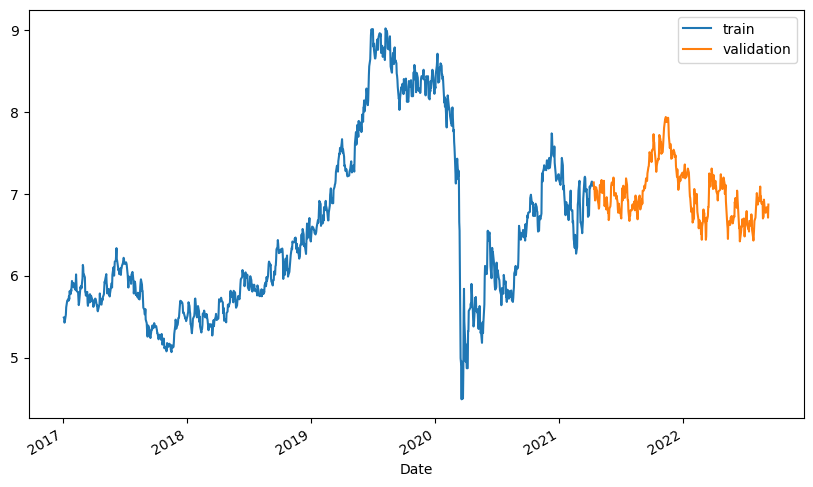

In [49]:
AIA_df = readX(list_csv[0])
AIA_df['Date'] = pd.to_datetime(AIA_df.index)
AIA_df = AIA_df.set_index(['Date'], drop=True)

split_date1 = pd.Timestamp('2017-01-03')
split_date2 = pd.Timestamp('2019-11-05')
split_date3 = pd.Timestamp('2021-04-09')
split_date4 = pd.Timestamp('2021-04-12')
split_date5 = pd.Timestamp('2022-09-08')

TV_AIA_df = AIA_df.loc[split_date1:split_date3]
Test_AIA_df = AIA_df.loc[split_date4:split_date5]

TV_AIA_cudf = cudf.from_pandas(TV_AIA_df)
Test_AIA_cudf = cudf.from_pandas(Test_AIA_df)

# Didn't include dividend and split
X_train = TV_AIA_cudf[["Volume", "OpenClose_spread", "Highlow_spread", "5_Days_MA", "10_Days_MA", "15_Days_MA", "30_Days_MA", "5_Days_VAR", "15_Days_VAR", "30_Days_VAR", 
                        "15_Days_EWMA", "15_Days_RSI", "15_Days_MFI", "15_Days_ATR", "ForceIndex", "Typical_MACD"]]
X_train_dividend = TV_AIA_cudf[["Dividends"]]
X_test = Test_AIA_cudf[["Volume", "OpenClose_spread", "Highlow_spread", "5_Days_MA", "10_Days_MA", "15_Days_MA", "30_Days_MA", "5_Days_VAR", "15_Days_VAR", "30_Days_VAR", 
                        "15_Days_EWMA", "15_Days_RSI", "15_Days_MFI", "15_Days_ATR", "ForceIndex", "Typical_MACD"]]
X_test_dividend = Test_AIA_cudf[["Dividends"]]
Y_train = TV_AIA_df[["Price"]]
Y_test = Test_AIA_df[["Price"]]

plt.figure(figsize=(10, 6))
ax = Y_train['Price'].plot()
Y_test['Price'].plot(ax=ax)
plt.legend(['train', 'validation'])

In [50]:
scales = [StandardScaler(), MinMaxScaler(), QuantileTransformer()]

## 3. Test and Criteria

In [51]:
def getScore(pipe_lr, X_valid, y_valid, prob = False):
    '''
    Get ROC
    '''
    y_pred = pipe_lr.predict(X_valid)
    if prob:
        y_pred = pipe_lr.predict_proba(X_valid)[:,1]
    print('ROC: %.4f' % roc_auc_score(y_true=y_valid, y_score=y_pred))

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = MSE(actuals, predictions)
    return mse

def getPrediction_ANN(predict_dl, model):
    predictions = list()
    for i, (inputs, targets) in enumerate(predict_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        predictions.append(yhat)
    predictions = vstack(predictions)
    
    return cudf.DataFrame(data=predictions)



Rolling windows

In [86]:
model_mse = []
Totaldatas = 720
Window = 30
Rollingtimes = 12

def RollingTrain(X_train, Y_train, times, selectedModel, scale):
    X1 = X_train[Window * times : Totaldatas + Window * times].values
    Y1 = Y_train[Window * times : Totaldatas + Window * times].values
    X1_ = X_train[Totaldatas + Window * times : Totaldatas + Window * (times + 1)].values
    Y1_ = Y_train[Totaldatas + Window * times : Totaldatas + Window * (times + 1)].values

    scaler = scale.fit(X1.get())
    X1_scaled = scaler.transform(X1.get())
    X1__scaled = scaler.fit_transform(X1_.get())
    model = selectedModel.fit(X1_scaled, Y1)
    prediction = model.predict(X1__scaled)
    mse = MSE(Y1_, prediction)
    model_mse.append(mse)

def TrainRolling(Rollingtimes, selectedModel, scale):
    for i in range(0, Rollingtimes):
        RollingTrain(X_train, Y_train, i, selectedModel, scale)
    return sum(model_mse) / len(model_mse)


## 4. Random Forest

### 4.1 Parameters to be considered

In [89]:
rf_n_estimators = [50, 100, 400, 800]
rf_max_depth = [50, 100, 400, 1000]
rf_max_leaves = [1000, 500, 200, 100]
rf_min_samples_split = [2, 10, 20, 50]
rf_n_bins = [32, 128, 512]

In [92]:
rf_parameters = []
def RandomForestTraining():
    averageMSE = []
    i = 0
    for n_estimators in rf_n_estimators:
        for max_depth in rf_max_depth:
            for max_leaves in rf_max_leaves:
                for min_samples_split in rf_min_samples_split:
                    for n_bins in rf_n_bins:
                        for scaler in scales:
                            rf = cumlRandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_leaves = max_leaves, min_samples_split = min_samples_split, n_bins = n_bins)
                            calculatedmse = TrainRolling(Rollingtimes, rf, scaler)
                            averageMSE.append(calculatedmse)
                            rf_parameters.append(["rf_n_estimators: ", n_estimators, "; rf_max_depth:", max_depth, "; rf_max_leaf_nodes: ", max_leaves, "; rf_min_samples_split: ", 
                                                min_samples_split, "; rf_n_bins: ", n_bins, "; scaler: ", scaler])
                            print(i, calculatedmse)
                            i += 1
    return averageMSE

In [93]:
x = RandomForestTraining()

0 1.7944626833049688
1 1.7936728831239879
2 1.7943656800551955
3 1.7943796112430135
4 1.793687952055826
5 1.7944944622322148
6 1.794538206651636
7 1.793772892716112
